Processing: Labels/orig/nucleus/2023_12_14_image_007.npy
Processing: Labels/orig/nucleus/2023_12_14_image_047.npy
Processing: Labels/orig/nucleus/2023_12_14_image_025.npy
Processing: Labels/orig/nucleus/2023_12_14_image_033.npy
Processing: Labels/orig/nucleus/2023_12_14_image_021.npy
Processing: Labels/orig/nucleus/2023_12_14_image_001.npy
Processing: Labels/orig/nucleus/2023_12_14_image_037.npy
Processing: Labels/orig/nucleus/2023_12_14_image_006.npy
Processing: Labels/orig/nucleus/2023_12_14_image_012.npy
Processing: Labels/orig/nucleus/2023_12_14_image_026.npy
Processing: Labels/orig/nucleus/2023_12_14_image_048.npy
Processing: Labels/orig/nucleus/2023_12_14_image_005.npy
Processing: Labels/orig/nucleus/2023_12_14_image_023.npy
Processing: Labels/orig/nucleus/2023_12_14_image_022.npy
Processing: Labels/orig/nucleus/2023_12_14_image_049.npy
Processing: Labels/orig/nucleus/2023_12_14_image_045.npy
Processing: Labels/orig/nucleus/2023_12_14_image_018.npy
Processing: Labels/orig/nucleus

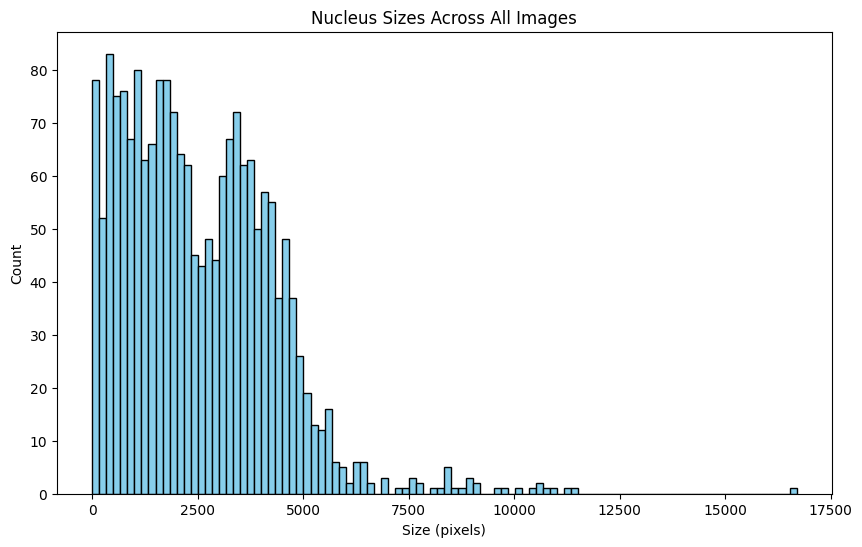

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.measure import regionprops
from skimage.io import imsave
import os
import glob

# Define directories
input_dir = "Labels/orig/nucleus/"
output_dir = "Nucleus_watershed/"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List to store all nucleus sizes
all_nucleus_sizes = []

# Loop through all .npy files in the input directory
for npy_file in glob.glob(os.path.join(input_dir, "*.npy")):
    print(f"Processing: {npy_file}")

    # Load the binary image
    binary_image = np.load(npy_file)

    # change 2 to 1
    binary_image[binary_image == 2] = 1

    distance_transform = ndimage.distance_transform_edt(binary_image)

    local_max = distance_transform == ndimage.maximum_filter(distance_transform, size=20)
    markers, _ = ndimage.label(local_max)

    color_image = cv2.cvtColor(binary_image.astype(np.uint8) * 255, cv2.COLOR_GRAY2BGR)
    color_image = cv2.applyColorMap(color_image, cv2.COLORMAP_JET)

    labels = cv2.watershed(color_image, markers)

    # Set background to 0 (in case any watershed background pixels are left as -1)
    labels[labels == 1] = 0

    # # Visualize the watershed result
    # plt.figure(figsize=(8, 8))
    # plt.imshow(labels, cmap='nipy_spectral')
    # plt.axis('off')
    # plt.title(f'Watershed Segmentation: {os.path.basename(npy_file)}')

    # Draw the labels and bounding boxes on the image
    for region in regionprops(labels):
        if region.label > 0:  # Ignore the background
            minr, minc, maxr, maxc = region.bbox

            # Draw a bounding box around each region
            cv2.rectangle(
                color_image, (minc, minr), (maxc, maxr), (0, 255, 0), 2
            )  # Green bounding box

            # Add the label text to the center of the bounding box
            label_position = ((minc + maxc) // 2, (minr + maxr) // 2)
            cv2.putText(
                color_image,
                str(region.label),
                label_position,
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255, 255, 255),
                1,
            )

    # Save the final image with labels and bounding boxes
    cv2.imwrite(
        os.path.join(output_dir, f"{os.path.basename(npy_file)}_watershed_labeled.png"), color_image
    )

    # Step 4: Measure the properties and count nucleus sizes
    regions = regionprops(labels)
    nucleus_sizes = [
        region.area for region in regions if region.label > 0
    ]  # Only consider labels > 0 (nuclei)

    # Add to the global list of nucleus sizes
    all_nucleus_sizes.extend(nucleus_sizes)

# After processing all images, print the total count and show the histogram
print(f"Total nuclei detected across all images: {len(all_nucleus_sizes)}")

# Plot the histogram of nucleus sizes
plt.figure(figsize=(10, 6))
plt.hist(all_nucleus_sizes, bins=100, color="skyblue", edgecolor="black")
plt.title("Nucleus Sizes Across All Images")
plt.xlabel("Size (pixels)")
plt.ylabel("Count")
plt.savefig(os.path.join(output_dir, "nucleus_size_histogram.png"))
plt.show()